In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import os
import joblib
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

In [11]:
plt.rcParams["axes.unicode_minus"] = False

if platform.system() == "Darwin":  # macOS
    rc("font", family="AppleGothic")
elif platform.system() == "Windows":  # Windows
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)
elif platform.system() == "Linux":  # Linux (Ubuntu, Docker 등)
    font_path = "fonts/NanumGothic.ttf"
    if not os.path.exists(font_path):
        st.error("NanumGothic.ttf 폰트 파일이 존재하지 않습니다. 'fonts' 폴더 내에 폰트 파일을 확인하세요.")
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

✅ LSTM 예측 성능 (과거 6개월 예측 실험)
 - R² Score: -0.5379
 - MAE: 2,198.18


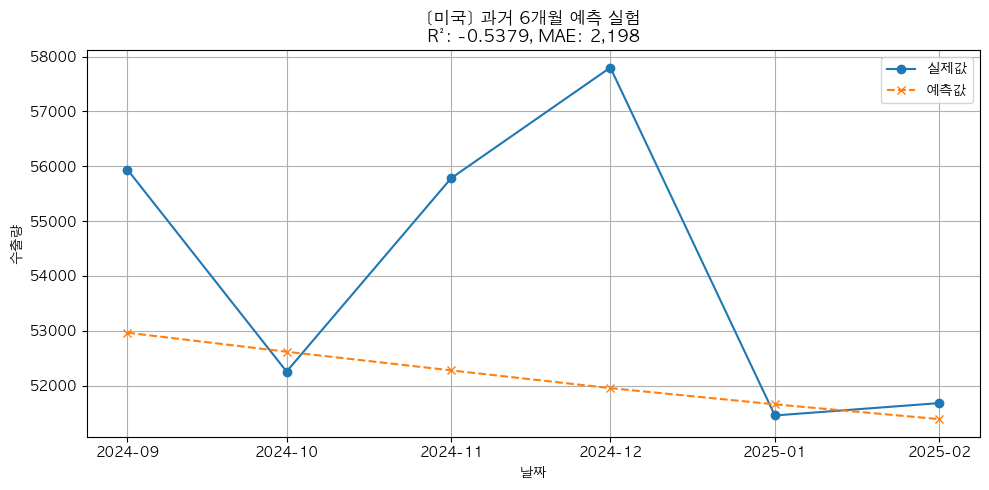

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta

# 1. 데이터 로딩
df = pd.read_csv("../../data/processed/현대_지역별수출실적_전처리.csv")
month_cols = [col for col in df.columns if col not in ['지역명', '대륙']]
df[month_cols] = df[month_cols].replace("-", 0).apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

# 2. 파라미터 설정
region = "미국"
seq_len = 18
n_eval_months = 6  # 검증용 예측 개월 수
epochs = 100

# 3. 시계열 생성
sub_df = df[df["지역명"] == region]
values = sub_df[month_cols].values.flatten()
start_date = datetime.strptime("2023-01", "%Y-%m")
date_range = pd.date_range(start=start_date, periods=len(values), freq="MS")

# 4. 평가 범위 확인
if len(values) < seq_len + n_eval_months:
    raise ValueError("데이터가 부족합니다.")

# 5. 훈련/검증 분할
train_values = values[:-(n_eval_months)]
eval_true_values = values[-n_eval_months:]

# 6. 스케일링
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values.reshape(-1, 1))

# 7. 시퀀스 생성 함수
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(train_scaled, seq_len)

# 8. LSTM 모델 학습
model = Sequential()
model.add(LSTM(32, input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=epochs, batch_size=4, verbose=0)

# 9. 평가용 입력 생성 → 마지막 seq_len 구간
eval_input = train_scaled[-seq_len:].reshape(1, seq_len, 1)
eval_preds_scaled = []

for _ in range(n_eval_months):
    pred = model.predict(eval_input)[0][0]
    eval_preds_scaled.append(pred)
    eval_input = np.append(eval_input[:, 1:, :], [[[pred]]], axis=1)

# 10. 역변환
eval_preds = scaler.inverse_transform(np.array(eval_preds_scaled).reshape(-1, 1)).flatten()

# 11. 평가 지표
r2 = r2_score(eval_true_values, eval_preds)
mae = mean_absolute_error(eval_true_values, eval_preds)

print(f"\n✅ LSTM 예측 성능 (과거 6개월 예측 실험)")
print(f" - R² Score: {r2:.4f}")
print(f" - MAE: {mae:,.2f}")

# 12. 시각화
eval_dates = date_range[-n_eval_months:]
plt.figure(figsize=(10, 5))
plt.plot(eval_dates, eval_true_values, label="실제값", marker='o')
plt.plot(eval_dates, eval_preds, label="예측값", linestyle='--', marker='x')
plt.title(f"[{region}] 과거 6개월 예측 실험\nR²: {r2:.4f}, MAE: {mae:,.0f}")
plt.xlabel("날짜")
plt.ylabel("수출량")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
print(df['지역'].unique())

['U.S.A' 'Canada' 'Mexico' 'Europe Subsidiaries' 'Europe Distributors'
 'Turkey' 'Latin America' 'Russia/CIS' 'Middle East/Africa' 'Asia/Pacific'
 'U.S.A.' 'GME']


In [43]:
df = pd.read_csv("../../data/processed/현대_해외공장판매실적_전처리.csv")
df

,Overseas Plants,Unnamed: 1,Unnamed: 2,2023년01,2023년02,2023년03,2023년04,2023년05,2023년06,2023년07,...,2024년04,2024년05,2024년06,2024년07,2024년08,2024년09,2024년10,2024년11,2024년12,2025년01
0,Export,Aura (AI3 4DR),HMI,1099.0,727.0,2311.0,1149.0,1039.0,2703.0,2963.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Domestic,Aura (AI3 4DR),HMI,4634.0,5524.0,3774.0,5085.0,4707.0,4907.0,4514.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Domestic,Celesta (ID),BHMC,764.0,1116.0,1560.0,165.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Domestic,Creta (SU2i EV),HMI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1735.0
4,Domestic,Creta (SU2i LWB),HMI,1537.0,1559.0,2519.0,2037.0,2443.0,2119.0,1443.0,...,1219.0,944.0,882.0,585.0,1105.0,2712.0,2204.0,2134.0,1342.0,1310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,Export,Tucson OB (NX4a OB),HMMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,395.0
241,Domestic,Tucson OB (NX4a OB),HMMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,Domestic,Tucson OB (NX4a OB),HMMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,Domestic,Venue (QXv),Vietnam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,508.0,698.0,189.0,62.0,40.0,360.0,350.0,290.0,287.0,299.0


In [ ]:
df.fillna